# Dementia classification w/ machine learning methods

Updated date: 3/14/2021

In [1]:
# Filter all warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import useful modules/packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix

RANDOM_STATE = 2021
# Evaluation metrics
scoring_ = 'f1_weighted'

In [3]:
# Read in data (output from R -- here we start from self-respondents)
self_train = pd.read_csv("/home/mingzhoufu/Dementia_classification/self_train.csv")
self_test = pd.read_csv("/home/mingzhoufu/Dementia_classification/self_test.csv")
self_train.head()

,AD_gold,RACE_SELF,SCHLYRS,AGE,SEX,LIVING,SMOKE,SER7,PROXY,SHLT,...,AD_langa,MSTAT,HIBP,DIAB,CANCR,LUNG,HEART,STROK,PSYCH,ARTHR
0,0,0,17,74,0,0,0,5,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,17,80,0,0,0,4,0,2,...,0,0,0,0,0,0,1,0,0,0
2,0,0,17,82,0,0,0,3,0,2,...,0,0,0,0,0,0,1,0,0,0
3,1,0,6,71,0,0,1,0,0,3,...,2,0,0,1,0,0,0,0,0,0
4,1,0,6,73,0,0,1,0,0,4,...,2,0,1,1,0,0,0,0,0,0


## Data wrangling w/ training and testing datasets

### 1) Training sample

In [4]:
X = self_train.drop(['AD_gold', 'AD_langa'], axis = 1)
y = self_train['AD_gold']
X.shape, y.shape

((1094, 45), (1094,))

In [5]:
# Get dummy variables for categorical variables -- most of the models need dummy variablesa
# categories = ['RACE_SELF', 'hrs_wave_near']
# categorical = pd.get_dummies(X[categories], dummy_na = False)
# continuous = X.drop(columns = categories)
# X = pd.concat([continuous, categorical], axis = 1)
# X.head()

### 2) Testing sample (independent)

In [6]:
X_test = self_test.drop(['AD_gold', 'AD_langa'], axis = 1)
y_test = self_test['AD_gold']
X_test.shape, y_test.shape

((262, 45), (262,))

In [7]:
# Get dummy variables for categorical variables
# categories = ['RACE_SELF', 'hrs_wave_near']
# categorical = pd.get_dummies(X_test[categories], dummy_na = False)
# continuous = X_test.drop(columns = categories)
# X_test = pd.concat([continuous, categorical], axis = 1)
# X_test.head()

### 3) Also we need to deal with scaling - feature normalization (for regularized regression, k-NN, SVM, etc.) -- faster convergence in learning, more uniform or "fair" influence for all weights

In [8]:
from sklearn.preprocessing import StandardScaler
# Import standard scaler -- mean = 0, sd = 1
scaler = StandardScaler()
columns = X.columns
standardized_X = X.copy()
standardized_X_test = X_test.copy()
# Standardize the testing sample based on the training sample
standardized_X[columns] = scaler.fit_transform(X[columns])
standardized_X_test[columns] = scaler.transform(X_test[columns])

In [9]:
standardized_X.head()

,RACE_SELF,SCHLYRS,AGE,SEX,LIVING,SMOKE,SER7,PROXY,SHLT,HLTC,...,VP,MSTAT,HIBP,DIAB,CANCR,LUNG,HEART,STROK,PSYCH,ARTHR
0,-0.481645,1.480678,-1.424097,-1.116426,-1.007473,-0.996360,1.188984,0.0,-2.045762,-0.373313,...,0.927655,-1.171794,-1.433829,-0.542839,-0.545661,-0.370424,-0.807817,-0.430425,-0.467186,-1.645744
1,-0.481645,1.480678,-0.452395,-1.116426,-1.007473,-0.996360,0.680879,0.0,-1.114012,-0.373313,...,0.927655,-1.171794,-1.433829,-0.542839,-0.545661,-0.370424,1.237904,-0.430425,-0.467186,-1.645744
2,-0.481645,1.480678,-0.128494,-1.116426,-1.007473,-0.996360,0.172774,0.0,-1.114012,-0.373313,...,0.927655,-1.171794,-1.433829,-0.542839,-0.545661,-0.370424,1.237904,-0.430425,-0.467186,-1.645744
3,-0.481645,-1.166548,-1.909948,-1.116426,-1.007473,0.675446,-1.351541,0.0,-0.182262,-0.373313,...,-1.077987,-1.171794,-1.433829,1.842166,-0.545661,-0.370424,-0.807817,-0.430425,-0.467186,-1.645744
4,-0.481645,-1.166548,-1.586047,-1.116426,-1.007473,0.675446,-1.351541,0.0,0.749488,-0.373313,...,0.927655,-1.171794,0.697433,1.842166,-0.545661,-0.370424,-0.807817,-0.430425,-0.467186,-1.645744


# Model fitting

We'll implement grid search cross-validation along with different modeling methods

In [10]:
# At first, we want to create a dataframe recording all model prediction
self_test_result = self_test.copy()

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 2, perplexity = 40, learning_rate = 1, early_exaggeration = 20, 
            random_state = RANDOM_STATE, verbose = 1)
tsne_results = tsne.fit_transform(X_test)
self_test_result['TSNE1'] = tsne_results[:,0]
self_test_result['TSNE2'] = tsne_results[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 262 samples in 0.000s...
[t-SNE] Computed neighbors for 262 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 262 / 262
[t-SNE] Mean sigma: 4.819704
[t-SNE] KL divergence after 50 iterations with early exaggeration: 95.006516
[t-SNE] KL divergence after 1000 iterations: 0.417586


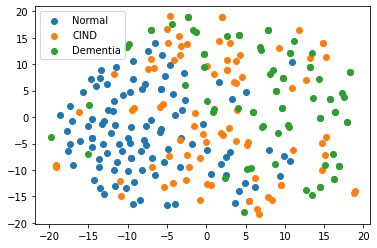

In [12]:
dementia_indices = np.where(y_test == 2)
# moderate_indices = np.where(y_test == 2)
# mild_dem_indices = np.where(y_test == 2)
# mild_impair_indices = np.where(y_test == 1)
CIND_indices = np.where(y_test == 1)
normal_indices = np.where(y_test == 0)

#plt.figure(figsize=(6, 6))
plt.scatter(tsne_results[normal_indices, 0], tsne_results[normal_indices, 1], label = 'Normal')
plt.scatter(tsne_results[CIND_indices, 0], tsne_results[CIND_indices, 1], label = 'CIND')
# plt.scatter(tsne_results[mild_impair_indices, 0], tsne_results[mild_impair_indices, 1], label = 'Mild Impairment')
# plt.scatter(tsne_results[mild_dem_indices, 0], tsne_results[mild_dem_indices, 1], label = 'Mild Dementia')
# plt.scatter(tsne_results[moderate_indices, 0], tsne_results[moderate_indices, 1], label = 'Moderate Dementia')
plt.scatter(tsne_results[dementia_indices, 0], tsne_results[dementia_indices, 1], label = 'Dementia')

plt.legend()
plt.show()

In [13]:
from collections import Counter

print('Oringinal train dataset shape', Counter(y))
print('Oringinal test dataset shape', Counter(y_test))

Oringinal train dataset shape Counter({0: 496, 1: 367, 2: 231})
Oringinal test dataset shape Counter({0: 104, 1: 81, 2: 77})


In [14]:
# utility class to compare the predictions versus ground truth
def comparePlot(input_frame, real_column, predicted_column):
    df_a = input_frame.copy()
    df_b = input_frame.copy()
    df_a['label_source'] = 'Gold standard'
    df_b['label_source'] = 'Classifier'
    df_a['label'] = df_a[real_column]
    df_b['label'] = df_b[predicted_column].apply(lambda x: 'Predict %s'%x)
    df_c = pd.concat((df_a, df_b), axis = 0, ignore_index = True)
    sns.lmplot(x = 'TSNE1', y = 'TSNE2', col = 'label_source',
               hue = 'label', data = df_c, fit_reg = False, size = 4);

## Benchmarking -- dummy classifier (sanity check on classifier's performance)

In [15]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

dummy_model = DummyClassifier(strategy = 'most_frequent', random_state = RANDOM_STATE).fit(standardized_X, y)
dummy_test_score = precision_recall_fscore_support(y_test, dummy_model.predict(standardized_X_test), average = 'weighted')
print("---Predicted value: {}---".format(np.unique(dummy_model.predict(standardized_X_test))))
print("Precision: {:.3f}".format(dummy_test_score[0]))
print("Recall: {:.3f}".format(dummy_test_score[1]))
print("F1: {:.3f}".format(dummy_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(dummy_model.predict(standardized_X_test), y_test)))

---Predicted value: [0]---
Precision: 0.158
Recall: 0.397
F1: 0.226
Accuracy: 0.397


In [16]:
langa_test_score = precision_recall_fscore_support(y_test, self_test['AD_langa'], average = 'weighted')
print("---Predicted value: {Langa-Weir Classification}---")
print("Precision: {:.3f}".format(langa_test_score[0]))
print("Recall: {:.3f}".format(langa_test_score[1]))
print("F1: {:.3f}".format(langa_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(self_test['AD_langa'], y_test)))

---Predicted value: {Langa-Weir Classification}---
Precision: 0.640
Recall: 0.626
F1: 0.631
Accuracy: 0.626


## k-Nearest Neighbor (k-NN)

In [17]:
from sklearn.neighbors import KNeighborsClassifier
# Default model
knn_model = KNeighborsClassifier().fit(standardized_X, y)
knn_test_score = precision_recall_fscore_support(y_test, knn_model.predict(standardized_X_test), average = 'weighted')
print("---Predicted value: {}---".format(np.unique(knn_model.predict(standardized_X_test))))
print("Precision: {:.3f}".format(knn_test_score[0]))
print("Recall: {:.3f}".format(knn_test_score[1]))
print("F1: {:.3f}".format(knn_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(knn_model.predict(standardized_X_test), y_test)))

---Predicted value: [0 1 2]---
Precision: 0.629
Recall: 0.595
F1: 0.588
Accuracy: 0.595


In [18]:
# Use grid search
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': [1, 3, 5, 7, 10], 'weights': ['uniform', 'distance']}
knn_model = KNeighborsClassifier()
knn_grid_cv = GridSearchCV(knn_model, parameters, cv = 5, scoring = scoring_)
knn_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1_weighted')

In [19]:
# get best dict
knn_best_id = np.argmin(knn_grid_cv.cv_results_["rank_test_score"])
knn_best_dict = knn_grid_cv.cv_results_["params"][knn_best_id]
# get test_score
knn_model = KNeighborsClassifier(**knn_best_dict).fit(standardized_X, y)
knn_test_score = precision_recall_fscore_support(y_test, knn_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(knn_best_dict))
print("Precision: {:.3f}".format(knn_test_score[0]))
print("Recall: {:.3f}".format(knn_test_score[1]))
print("F1: {:.3f}".format(knn_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(knn_model.predict(standardized_X_test), y_test)))

---Best parameters: {'n_neighbors': 5, 'weights': 'uniform'}---
Precision: 0.629
Recall: 0.595
F1: 0.588
Accuracy: 0.595


In [20]:
knn_labels = knn_model.predict(standardized_X_test)
self_test_result['predicted_label_knn'] = knn_labels

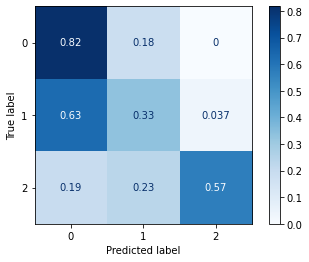

In [21]:
plot_confusion_matrix(knn_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [22]:
# comparePlot(self_test_result, "AD_gold_cat2", "predicted_label_knn")

## Random forest

In [23]:
from sklearn.ensemble import RandomForestClassifier
# Default model
rf_model = RandomForestClassifier(random_state = RANDOM_STATE).fit(X, y)
rf_test_score = precision_recall_fscore_support(y_test, rf_model.predict(X_test), average = 'weighted')
print("Precision: {:.3f}".format(rf_test_score[0]))
print("Recall: {:.3f}".format(rf_test_score[1]))
print("F1: {:.3f}".format(rf_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(rf_model.predict(X_test), y_test)))

Precision: 0.718
Recall: 0.702
F1: 0.706
Accuracy: 0.702


In [24]:
# build a random forest
parameters = {'n_estimators': [10, 50, 100], 'max_features': [1, 5, 10, 20, 'auto'], 
              'criterion': ['gini', 'entropy'], 'oob_score': [True, False]}
rf_model = RandomForestClassifier()
rf_grid_cv = GridSearchCV(rf_model, parameters, cv = 5, scoring = scoring_)
rf_grid_cv.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': [1, 5, 10, 20, 'auto'],
                         'n_estimators': [10, 50, 100],
                         'oob_score': [True, False]},
             scoring='f1_weighted')

In [25]:
# get best dict
rf_best_id = np.argmin(rf_grid_cv.cv_results_["rank_test_score"])
rf_best_dict = rf_grid_cv.cv_results_["params"][rf_best_id]
# get test_score
rf_model = RandomForestClassifier(**rf_best_dict, random_state = RANDOM_STATE).fit(X, y)
rf_test_score = precision_recall_fscore_support(y_test, rf_model.predict(X_test), average = 'weighted')
print("---Best parameters: {}---".format(rf_best_dict))
print("Precision: {:.3f}".format(rf_test_score[0]))
print("Recall: {:.3f}".format(rf_test_score[1]))
print("F1: {:.3f}".format(rf_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(rf_model.predict(X_test), y_test)))

---Best parameters: {'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 50, 'oob_score': False}---
Precision: 0.688
Recall: 0.687
F1: 0.686
Accuracy: 0.687


In [26]:
rf_model = RandomForestClassifier(random_state = RANDOM_STATE).fit(X, y)
rf_labels = rf_model.predict(X_test)
self_test_result['predicted_label_rf'] = rf_labels

In [27]:
rf_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2021,
 'verbose': 0,
 'warm_start': False}

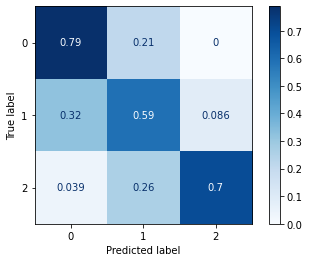

In [28]:
plot_confusion_matrix(rf_model, X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [29]:
# comparePlot(self_test_result, "AD_gold", "predicted_label_rf")

<AxesSubplot:>

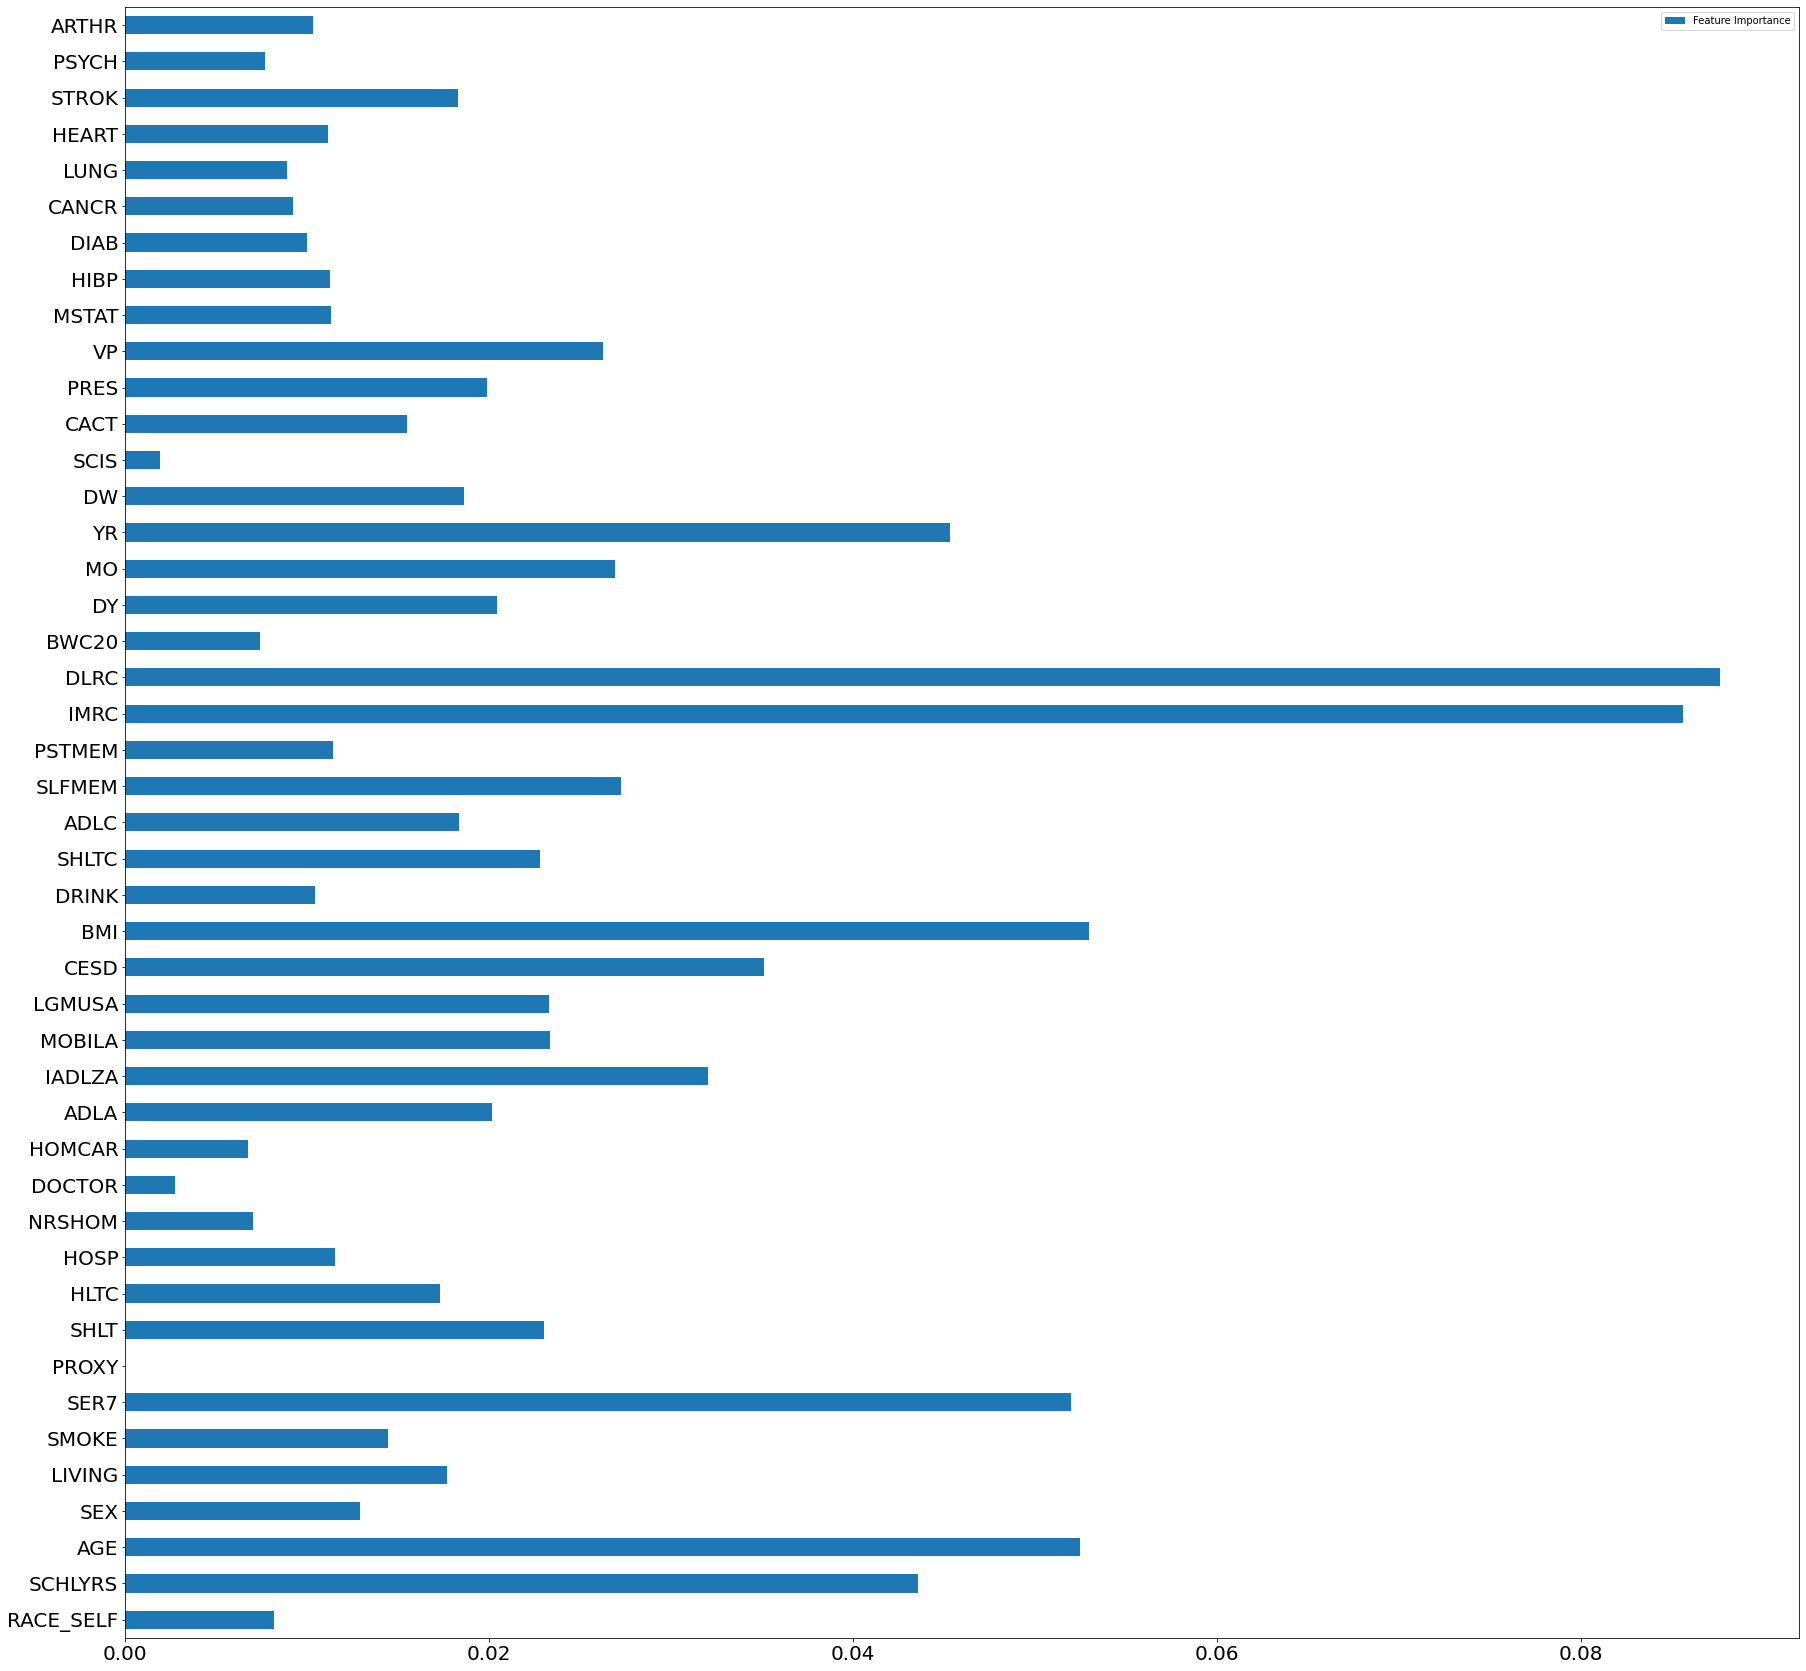

In [30]:
# Check feature importance
rf_feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance': rf_feat_importance},
            index = X.columns[:]).plot(kind = 'barh', fontsize = 20, figsize = (30, 30))

## Support Vector Machine (SVM)

In [31]:
from sklearn.svm import SVC
# Default model
svm_model = SVC(random_state = RANDOM_STATE).fit(standardized_X, y)
svm_test_score = precision_recall_fscore_support(y_test, svm_model.predict(standardized_X_test), average = 'weighted')
print("Precision: {:.3f}".format(svm_test_score[0]))
print("Recall: {:.3f}".format(svm_test_score[1]))
print("F1: {:.3f}".format(svm_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(svm_model.predict(standardized_X_test), y_test)))

Precision: 0.695
Recall: 0.676
F1: 0.682
Accuracy: 0.676


In [32]:
# apply gridsearchcv
parameters = {'kernel': ['linear', 'rbf', 'polynomial'], 'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100]}
svm_model = SVC()
svm_grid_cv = GridSearchCV(svm_model, parameters, cv = 5, scoring = scoring_)
svm_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [0.1, 1, 10, 100],
                         'kernel': ['linear', 'rbf', 'polynomial']},
             scoring='f1_weighted')

In [33]:
# get best dict
svm_best_id = np.argmin(svm_grid_cv.cv_results_["rank_test_score"])
svm_best_dict = svm_grid_cv.cv_results_["params"][svm_best_id]
# get test_score
svm_model = SVC(**svm_best_dict, random_state = RANDOM_STATE).fit(standardized_X, y)
svm_test_score = precision_recall_fscore_support(y_test, svm_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(svm_best_dict))
print("Precision: {:.3f}".format(svm_test_score[0]))
print("Recall: {:.3f}".format(svm_test_score[1]))
print("F1: {:.3f}".format(svm_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(svm_model.predict(standardized_X_test), y_test)))

---Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}---
Precision: 0.671
Recall: 0.664
F1: 0.666
Accuracy: 0.664


In [35]:
svm_model = SVC(random_state = RANDOM_STATE).fit(standardized_X, y)
svm_labels = svm_model.predict(standardized_X_test)
self_test_result['predicted_label_svm'] = svm_labels

In [36]:
svm_model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 2021,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

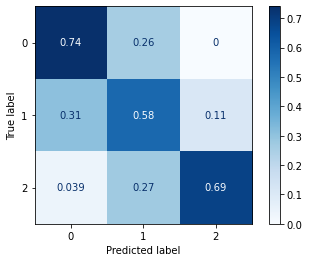

In [37]:
plot_confusion_matrix(svm_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [38]:
# comparePlot(self_test_result, "AD_gold", "predicted_label_svm")

## Logistic regression

In [50]:
from sklearn.linear_model import LogisticRegression
# Default model
lr_model = LogisticRegression(random_state = RANDOM_STATE).fit(standardized_X, y)
lr_test_score = precision_recall_fscore_support(y_test, lr_model.predict(standardized_X_test), average = 'weighted')
print("Precision: {:.3f}".format(lr_test_score[0]))
print("Recall: {:.3f}".format(lr_test_score[1]))
print("F1: {:.3f}".format(lr_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(lr_model.predict(standardized_X_test), y_test)))

Precision: 0.672
Recall: 0.672
F1: 0.671
Accuracy: 0.672


In [51]:
parameters = {'penalty': ['l1', 'l2', 'elasticnet'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'class_weight': [None, 'balanced']}
lr_model = LogisticRegression()
lr_grid_cv = GridSearchCV(lr_model, parameters, cv = 5, scoring = scoring_)
lr_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1_weighted')

In [52]:
# get best dict
lr_best_id = np.argmin(lr_grid_cv.cv_results_["rank_test_score"])
lr_best_dict = lr_grid_cv.cv_results_["params"][lr_best_id]
# get test_score
lr_model = LogisticRegression(**lr_best_dict, random_state = RANDOM_STATE).fit(standardized_X, y)
lr_test_score = precision_recall_fscore_support(y_test, lr_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(lr_best_dict))
print("Precision: {:.3f}".format(lr_test_score[0]))
print("Recall: {:.3f}".format(lr_test_score[1]))
print("F1: {:.3f}".format(lr_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(lr_model.predict(standardized_X_test), y_test)))

---Best parameters: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}---
Precision: 0.698
Recall: 0.706
F1: 0.700
Accuracy: 0.706


In [77]:
print(lr_model.coef_)

[[-2.41762661e-02  3.67169668e-02 -6.10883930e-02  1.67567950e-02
  -1.12742913e-02 -1.99464314e-02  7.95486215e-02  0.00000000e+00
  -2.89205163e-02 -1.23247573e-02 -2.08746212e-02 -2.77139805e-02
   1.44640602e-02 -1.36372499e-02 -2.93185818e-02 -5.07600332e-02
  -2.00460763e-02  4.74328143e-04 -3.31928355e-02  3.53181132e-02
   1.39360317e-02  1.23044936e-02 -1.41917757e-02 -5.18435955e-02
  -8.82982237e-04  1.08799244e-01  1.32895051e-01  4.04540269e-02
   6.77934062e-02  4.96050159e-02  7.35231145e-02  5.46670887e-02
   1.94546728e-02  4.65617746e-02  3.94691395e-02  7.87730380e-02
  -2.00057809e-02  2.30528095e-02 -9.75472564e-03  5.81493631e-03
  -1.24790332e-02 -2.53984703e-02 -6.59954316e-02 -3.10954081e-03
   2.51852693e-02]
 [ 3.07721213e-02 -4.23269134e-02 -2.76693316e-03 -5.54054871e-02
   2.22047049e-02  2.05243891e-02 -3.14104270e-02  0.00000000e+00
   2.87955404e-02 -1.52600321e-03  2.09053706e-02 -7.53261792e-03
  -1.65142757e-02  1.03229284e-03  1.11687336e-02 -1.8025

In [44]:
lr_labels = lr_model.predict(standardized_X_test)
self_test_result['predicted_label_lr'] = lr_labels

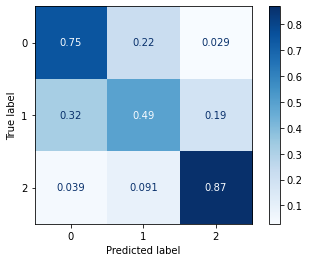

In [45]:
plot_confusion_matrix(lr_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [46]:
# comparePlot(self_test_result, "AD_gold", "predicted_label_lr")

## Gradient Boosting

In [53]:
from sklearn.ensemble import GradientBoostingClassifier
# Default model
gb_model = GradientBoostingClassifier(random_state = RANDOM_STATE).fit(standardized_X, y)
gb_test_score = precision_recall_fscore_support(y_test, gb_model.predict(standardized_X_test), average = 'weighted')
print("Precision: {:.3f}".format(gb_test_score[0]))
print("Recall: {:.3f}".format(gb_test_score[1]))
print("F1: {:.3f}".format(gb_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(gb_model.predict(standardized_X_test), y_test)))

Precision: 0.679
Recall: 0.676
F1: 0.674
Accuracy: 0.676


In [48]:
parameters = {'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100], 'n_estimators': [100, 1000], 
              'max_depth': [3, 5, 7, 10], 'loss': ['deviance', 'exponential']}
gb_model = GradientBoostingClassifier()
gb_grid_cv = GridSearchCV(gb_model, parameters, cv = 5, scoring = scoring_)
gb_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 1, 10, 100],
                         'loss': ['deviance', 'exponential'],
                         'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 1000]},
             scoring='f1_weighted')

In [54]:
# get best dict
gb_best_id = np.argmin(gb_grid_cv.cv_results_["rank_test_score"])
gb_best_dict = gb_grid_cv.cv_results_["params"][gb_best_id]
# get test_score
gb_model = GradientBoostingClassifier(**gb_best_dict, random_state = RANDOM_STATE).fit(standardized_X, y)
gb_test_score = precision_recall_fscore_support(y_test, gb_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(gb_best_dict))
print("Precision: {:.3f}".format(gb_test_score[0]))
print("Recall: {:.3f}".format(gb_test_score[1]))
print("F1: {:.3f}".format(gb_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(gb_model.predict(standardized_X_test), y_test)))

---Best parameters: {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100}---
Precision: 0.679
Recall: 0.676
F1: 0.674
Accuracy: 0.676


In [55]:
gb_model = GradientBoostingClassifier(random_state = RANDOM_STATE).fit(standardized_X, y)
gb_labels = gb_model.predict(standardized_X_test)
self_test_result['predicted_label_gb'] = gb_labels

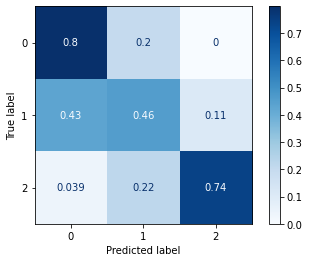

In [56]:
plot_confusion_matrix(gb_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [57]:
gb_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 2021,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [58]:
# comparePlot(self_test_result, "AD_gold", "predicted_label_gb")

## XGBoosting

In [59]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state = RANDOM_STATE, verbosity = 0).fit(standardized_X, y)
xgb_test_score = precision_recall_fscore_support(y_test, xgb_model.predict(standardized_X_test), average = 'weighted')
print("Precision: {:.3f}".format(xgb_test_score[0]))
print("Recall: {:.3f}".format(xgb_test_score[1]))
print("F1: {:.3f}".format(xgb_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(xgb_model.predict(standardized_X_test), y_test)))

Precision: 0.694
Recall: 0.683
F1: 0.685
Accuracy: 0.683


In [60]:
parameters = {'booster': ['gbtree', 'gblinear'], 'eta': [0.001, 0.3, 0.8], 'gamma': [0, 5, 10, 30], 
              'max_depth': [3, 6, 10], 'subsample': [0.1, 0.5], 'sampling_method': ['uniform', 'gradient_based'],
              'lambda': [0.01, 0.1, 1], 'alpha': [0, 0.01, 0.1, 1], 'verbosity': [0]}
xgb_model = XGBClassifier()
xgb_grid_cv = GridSearchCV(xgb_model, parameters, cv = 5, scoring = scoring_)
xgb_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             param_grid={'alpha': [0, 0.01, 0.1, 1],
                   

In [73]:
# get best dict
xgb_best_id = np.argmin(xgb_grid_cv.cv_results_["rank_test_score"])
xgb_best_dict = xgb_grid_cv.cv_results_["params"][xgb_best_id]
# get test_score
xgb_model = XGBClassifier(**xgb_best_dict, random_state = RANDOM_STATE).fit(standardized_X, y)
xgb_test_score = precision_recall_fscore_support(y_test, xgb_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(xgb_best_dict))
print("Precision: {:.3f}".format(xgb_test_score[0]))
print("Recall: {:.3f}".format(xgb_test_score[1]))
print("F1: {:.3f}".format(xgb_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(xgb_model.predict(standardized_X_test), y_test)))

---Best parameters: {'alpha': 0.01, 'booster': 'gblinear', 'eta': 0.8, 'gamma': 0, 'lambda': 0.01, 'max_depth': 3, 'sampling_method': 'uniform', 'subsample': 0.1, 'verbosity': 0}---
Precision: 0.694
Recall: 0.702
F1: 0.693
Accuracy: 0.702


In [62]:
# xgb_model = XGBClassifier(random_state = RANDOM_STATE, verbosity = 0).fit(standardized_X, y)
xgb_labels = xgb_model.predict(standardized_X_test)
self_test_result['predicted_label_xgb'] = xgb_labels

In [57]:
# xgb_model.get_params()

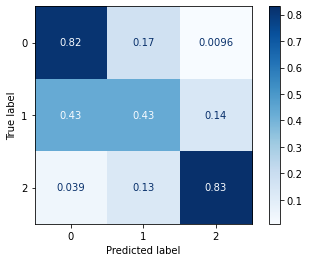

In [64]:
plot_confusion_matrix(xgb_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

In [58]:
# comparePlot(self_test_result, "AD_gold", "predicted_label_xgb")

## AdaBoosting

In [65]:
from sklearn.ensemble import AdaBoostClassifier
ada_model = AdaBoostClassifier(random_state = RANDOM_STATE).fit(standardized_X, y)
ada_test_score = precision_recall_fscore_support(y_test, ada_model.predict(standardized_X_test), average = 'weighted')
print("Precision: {:.3f}".format(ada_test_score[0]))
print("Recall: {:.3f}".format(ada_test_score[1]))
print("F1: {:.3f}".format(ada_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(ada_model.predict(standardized_X_test), y_test)))

Precision: 0.687
Recall: 0.691
F1: 0.686
Accuracy: 0.691


In [66]:
parameters = {'n_estimators': [50, 100, 500], 'learning_rate': [0.001, 0.1, 1, 10]}
ada_model = AdaBoostClassifier()
ada_grid_cv = GridSearchCV(ada_model, parameters, cv = 5, scoring = scoring_)
ada_grid_cv.fit(standardized_X, y)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(),
             param_grid={'learning_rate': [0.001, 0.1, 1, 10],
                         'n_estimators': [50, 100, 500]},
             scoring='f1_weighted')

In [74]:
# get best dict
ada_best_id = np.argmin(ada_grid_cv.cv_results_["rank_test_score"])
ada_best_dict = ada_grid_cv.cv_results_["params"][ada_best_id]
# get test_score
ada_model = AdaBoostClassifier(**ada_best_dict, random_state = RANDOM_STATE).fit(standardized_X, y)
ada_test_score = precision_recall_fscore_support(y_test, ada_model.predict(standardized_X_test), average = 'weighted')
print("---Best parameters: {}---".format(ada_best_dict))
print("Precision: {:.3f}".format(ada_test_score[0]))
print("Recall: {:.3f}".format(ada_test_score[1]))
print("F1: {:.3f}".format(ada_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(ada_model.predict(standardized_X_test), y_test)))

---Best parameters: {'learning_rate': 0.1, 'n_estimators': 500}---
Precision: 0.718
Recall: 0.718
F1: 0.717
Accuracy: 0.718


In [68]:
ada_labels = ada_model.predict(standardized_X_test)
self_test_result['predicted_label_ada'] = ada_labels

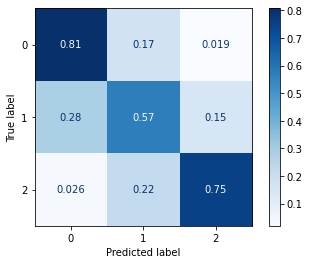

In [69]:
plot_confusion_matrix(ada_model, standardized_X_test, y_test, cmap = plt.cm.Blues, normalize = "true")  
plt.show() 

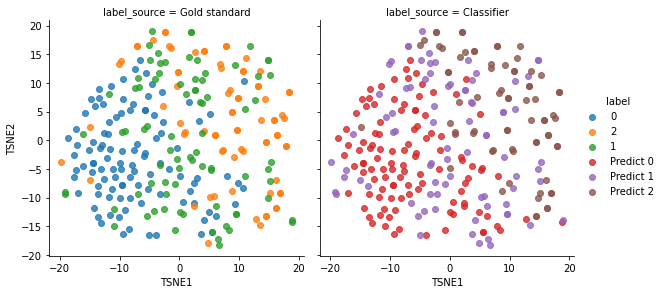

In [70]:
comparePlot(self_test_result, "AD_gold", "predicted_label_ada")

# Performance check

In [71]:
self_test_result.head()

,AD_gold,RACE_SELF,SCHLYRS,AGE,SEX,LIVING,SMOKE,SER7,PROXY,SHLT,...,ARTHR,TSNE1,TSNE2,predicted_label_knn,predicted_label_rf,predicted_label_svm,predicted_label_lr,predicted_label_gb,predicted_label_xgb,predicted_label_ada
0,0,0,17,73,0,0,0,5,0,2,...,0,-11.617128,-13.122900,0,0,0,0,0,0,0
1,0,0,17,77,0,0,0,4,0,3,...,0,-13.580361,-13.397610,0,0,0,0,0,0,0
2,0,0,17,79,0,0,0,5,0,2,...,0,-13.051303,-14.508873,0,0,0,0,0,0,0
3,2,1,3,73,0,1,1,0,0,2,...,1,4.822290,-17.997343,2,2,2,2,2,2,1
4,2,1,3,79,0,1,1,0,0,5,...,1,9.613078,1.720720,2,2,1,2,2,2,2


In [72]:
# Output for analysis
self_test_result.to_csv(r'/home/mingzhoufu/Dementia_classification/classfication_outputs.csv')

### This is an additional step to check for the Expert model:

In [75]:
expert_check = pd.read_csv("/home/mingzhoufu/Dementia_classification/output_testing2.csv")
expert_check.head()

,X,AD_gold,RACE_SELF,SCHLYRS,AGE,SEX,LIVING,SMOKE,SER7,PROXY,...,TSNE1,TSNE2,predicted_label_knn,predicted_label_rf,predicted_label_svm,predicted_label_lr,predicted_label_gb,predicted_label_xgb,predicted_label_ada,predicted_label_expert
0,0,0,0,17,73,0,0,0,5,0,...,-11.617128,-13.122900,0,0,0,0,0,0,0,0
1,1,0,0,17,77,0,0,0,4,0,...,-13.580361,-13.397610,0,0,0,0,0,0,0,0
2,2,0,0,17,79,0,0,0,5,0,...,-13.051303,-14.508873,0,0,0,0,0,0,0,0
3,3,2,1,3,73,0,1,1,0,0,...,4.822290,-17.997343,2,2,2,2,2,2,1,1
4,4,2,1,3,79,0,1,1,0,0,...,9.613078,1.720720,2,2,1,2,2,2,2,1


In [76]:
expert_test_score = precision_recall_fscore_support(y_test, expert_check['predicted_label_expert'], average = 'weighted')
print("---Predicted value: {The Expert Model Classification}---")
print("Precision: {:.3f}".format(expert_test_score[0]))
print("Recall: {:.3f}".format(expert_test_score[1]))
print("F1: {:.3f}".format(expert_test_score[2]))
print("Accuracy: {:.3f}".format(accuracy_score(expert_check['predicted_label_expert'], y_test)))

---Predicted value: {The Expert Model Classification}---
Precision: 0.667
Recall: 0.664
F1: 0.663
Accuracy: 0.664
